In [1]:
import keras.backend as K
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from keras_vggface.vggface import VGGFace
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from keras import regularizers
import os

Using TensorFlow backend.
/home/workstation/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/workstation/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/workstation/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [2]:
#setear carpetas
DATA1 = "/home/workstation/Desktop/fv/data/pics/pic1/"
DATA2 = "/home/workstation/Desktop/fv/data/pics/pic2/"
TOP_DATA = "/home/workstation/Desktop/fv/topwanted/"
ALL_DATA = "/home/workstation/Desktop/fv/allwanted/"
LOWCOUNT = "/home/workstation/Desktop/fv/lowcount/"
FACES = '/home/workstation/Desktop/fv/faces/'
FIT_DATA ="/home/workstation/Desktop/fv/fit/"
val_dir = "/home/workstation/Desktop/fv/fit/val/"
train_dir = "/home/workstation/Desktop/fv/fit/train/"
test_dir = "/home/workstation/Desktop/fv/fit/test/"

carpetas = [ DATA1, DATA2, TOP_DATA, ALL_DATA, LOWCOUNT, FACES, FIT_DATA,val_dir ,train_dir ,test_dir]

for carpeta in carpetas:
    if not os.path.exists(carpeta):
        os.mkdir(carpeta)
        
predict = '/home/workstation/Desktop/fv/perdictions/preds/'
crops = '/home/workstation/Desktop/fv/predictions/crops/'

In [3]:
#dtype='float16'
#K.set_floatx(dtype)
#default is 1e-7 which is too small for float16.  Without adjusting the epsilon, we will get NaN predictions because of divide by zero problems
#K.set_epsilon(1e-4) 

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)



In [4]:
# create a vggface2 model
conv_base = VGGFace(model='vgg16', include_top=False, input_shape=(130,130,3))

In [5]:
#arquitectura
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(1000, activation='softmax'))

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv3' or layer.name == 'block5_conv1' or layer.name == 'block5_conv2':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:layer.trainable = False

In [6]:
#data gen y vectorizacion

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(130, 130), batch_size=80,class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(val_dir, target_size=(130, 130), batch_size=20, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(130, 130), batch_size=20, class_mode='categorical')
labels = (test_generator.class_indices)

Found 1001000 images belonging to 1000 classes.
Found 15017 images belonging to 1000 classes.
Found 11192 images belonging to 1000 classes.


In [7]:
import simplejson as json
json = json.dumps(labels)#falta poner la carpeta correcta
f = open("dict1000.json","w")
f.write(json)
f.close()

In [8]:
class EarlyStoppingByValAcc(Callback):
    def __init__(self, monitor='val_acc', value=0.98, verbose=1):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current > self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [9]:
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4 ),
metrics=['acc'])

callbacks = [
             EarlyStoppingByValAcc(monitor='val_acc', value=0.95, verbose=1),
            ]

history = model.fit_generator(train_generator, steps_per_epoch=300, epochs=100, validation_data=validation_generator, validation_steps=40, callbacks=callbacks)


Epoch 1/100
300/300 [==============================] - 69s 229ms/step - loss: 6.1702 - acc: 0.0841 - val_loss: 4.3586 - val_acc: 0.2950
Epoch 2/100
300/300 [==============================] - 64s 214ms/step - loss: 3.9220 - acc: 0.3616 - val_loss: 2.7432 - val_acc: 0.5462
Epoch 3/100
300/300 [==============================] - 64s 214ms/step - loss: 2.8986 - acc: 0.5013 - val_loss: 2.9602 - val_acc: 0.6675
Epoch 4/100
300/300 [==============================] - 64s 213ms/step - loss: 2.4506 - acc: 0.5705 - val_loss: 0.6366 - val_acc: 0.7188
Epoch 5/100
300/300 [==============================] - 64s 214ms/step - loss: 2.1928 - acc: 0.6113 - val_loss: 1.7509 - val_acc: 0.7525
Epoch 6/100
300/300 [==============================] - 65s 215ms/step - loss: 2.0298 - acc: 0.6376 - val_loss: 1.7407 - val_acc: 0.7800
Epoch 7/100
300/300 [==============================] - 64s 213ms/step - loss: 1.9147 - acc: 0.6589 - val_loss: 1.0472 - val_acc: 0.7750
Epoch 8/100
300/300 [==========================

In [ ]:
#primer entrenamiento con optimizador peqieño
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=3e-4 ),
metrics=['acc'])

callbacks = [
             EarlyStoppingByValAcc(monitor='val_acc', value=0.9507, verbose=1),
            ]

history = model.fit_generator(train_generator, steps_per_epoch=200, epochs=200, validation_data=validation_generator, validation_steps=40, callbacks=callbacks)

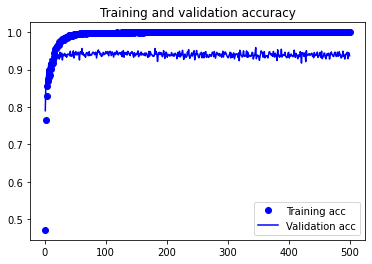

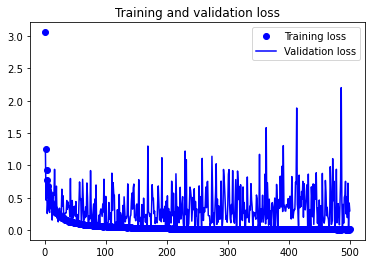

In [10]:
#graficas de acc y loss, en training y validation

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [17]:
#testeando el performance
results = model.evaluate_generator(test_generator, 1000)
print(results)

[0.382080078125, 0.97900390625]


In [11]:
#salvando el modelo
model.save('Top500_t9790.h5')